# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [118]:
#pip install wordcloud

In [119]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [120]:
# Use this space for any additional import statements you need
import nltk

In [525]:
#test_text = ["I'll use this this as test text 💜🍒 ."]
df_test = pd.DataFrame({'sentences': ['This, is going to be a Test Test test, test test Test 🍒.', 
                                      "It's really not that #hard, huh?"]})
df_test.head()

,sentences
0,"This, is going to be a Test Test test, test te..."
1,"It's really not that #hard, huh?"


In [526]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """
    total_types = []
    true_total = []
    num_tokens = 0
    num_unique_tokens = 0
    lexical_diversity = 0.0
    num_characters = 0

    #get unique list of tokens
    for token in tokens:
        #print(token)
        for i in token:
            true_total.append(i)
            num_tokens += 1
            if i in total_types:
                pass
            else:
                total_types.append(i)
                num_unique_tokens += 1
            for character in i:
                num_characters +=1
                
    lexical_diversity = round(num_unique_tokens / num_tokens , 3)
                
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")    

    #collect the 5 most common tokens
    counter_list = Counter(true_total)
    top_5 = counter_list.most_common(5)
    print(top_5)

    return([num_tokens, num_unique_tokens,lexical_diversity,num_characters])

#find the count of emojis within the dataframe
def contains_emoji(s):
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]
    return(len(emojis) > 0)

#remove the stop workds from the dataframe
def remove_stop(tokens) :
    stop_words = set(stopwords.words("english"))
    return [word for word in tokens if word.lower() not in stop_words]
 
#remove the punctuation from the dataframe
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

#create the tokens by splitting on whitespace
def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    return re.split(whitespace_pattern, text)

#defind the function for preparing the data for the pipeline
def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)

##### Test the pipeline on a smaller test dataframe

In [530]:
# apply the test pipeline to the test dataframe
my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

df_test["tokens"] = df_test["sentences"].apply(prepare,pipeline=my_pipeline)
df_test["num_tokens"] = df_test["tokens"].map(len) 

In [531]:
df_test['has_emoji'] = df_test["sentences"].apply(contains_emoji)
df_test.head()

,sentences,tokens,num_tokens,has_emoji
0,"This, is going to be a Test Test test, test te...","[going, test, test, test, test, test, test, 🍒]",8,True
1,"It's really not that #hard, huh?","[really, #hard, huh]",3,False


In [532]:
descriptive_stats(df_test['tokens'])

There are 11 tokens in the data.
There are 6 unique tokens in the data.
There are 44 characters in the data.
The lexical diversity is 0.545 in the data.
[('test', 6), ('going', 1), ('🍒', 1), ('really', 1), ('#hard', 1)]


[11, 6, 0.545, 44]

Validated that hashtags and emojis are still in the data, and all tokens are lowercase

## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

##### Import the Twitter Data

In [420]:
# Feel free to use the below cells as an example or read in the data in a way you prefer

data_location = "" # change to your location if it is not in the same directory as your notebook
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


In [421]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"
twitter_data.head()

,screen_name,name,id,location,followers_count,friends_count,description,artist
0,hsmcnp,Country Girl,35152213,NaN,1302,1014,NaN,cher
1,horrormomy,Jeny,742153090850164742,Earth,81,514,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,cher
2,anju79990584,anju,1496463006451974150,NaN,13,140,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,cher
3,gallionjenna,J,3366479914,NaN,752,556,csu,cher
4,bcscomm,bcscomm,83915043,"Washington, DC",888,2891,Writer @Washinformer @SpelmanCollege alumna #D...,cher


In [422]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)
twitter_data.tail()

,screen_name,name,id,location,followers_count,friends_count,description,artist
358367,jakegiles,Jake Giles,19725102,LA,7690,2165,"singer of songs, type 1 diabetic, tired $jakel...",robyn
358368,axelbluhme,Axel Bluhme,19573759,DK,238,1565,Dadx2/ Con-Arch/ Photographer/ DK #stemgrønnes...,robyn
358369,RayRayRay27,Rachael :),19919217,Oldham,762,1479,A year to change a life is still a year ✨😌,robyn
358370,bhandberg,Ben Handberg,12642462,Sydney,432,593,Head of Consumer - Mango. Made in Melbourne. R...,robyn
358371,takemeback,Christine,15022058,New Jersey,182,260,"Stand for what is right, even if you stand alone.",robyn


##### Import the Lyrics Data

In [363]:
#cher lyrics import
cher_path = '/Users/ryan_s_dunn/Documents/USD MS-ADS/Applied Text Mining ADS 509/Module 2/M1 Results/lyrics/cher'
file_list = [f for f in os.listdir(cher_path) if f.endswith('.txt')]

#iterate through file list and place all paths in data list
data = []
for f in file_list:
    with open(os.path.join(cher_path, f), 'r') as file:
        data.append(file.read())
        
#assign the lyrics to a dataframe
cher_lyrics = pd.DataFrame({'lyrics': data})
cher_lyrics.head(1)

,lyrics
0,"""Come And Stay With Me""\n\n\n\nI'll send away ..."


In [364]:
#robyn lyrics import
robyn_path = '/Users/ryan_s_dunn/Documents/USD MS-ADS/Applied Text Mining ADS 509/Module 2/M1 Results/lyrics/robyn'
file_list = [f for f in os.listdir(robyn_path) if f.endswith('.txt')]

#iterate through file list and place all paths in data list
data = []
for f in file_list:
    with open(os.path.join(robyn_path, f), 'r') as file:
        data.append(file.read())

#assign the lyrics to a dataframe
robyn_lyrics = pd.DataFrame({'lyrics': data})
robyn_lyrics.head(1)

,lyrics
0,"""Include Me Out""\n\n\n\nIt is really very simp..."


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [423]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5
my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

##### DO NOT RUN THE TWITTER PIPELINE AGAIN!!!

In [424]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5
my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 

In [524]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)
twitter_data.head(1)

,screen_name,name,id,location,followers_count,friends_count,description,artist,tokens,num_tokens,has_emoji
0,hsmcnp,Country Girl,35152213,NaN,1302,1014,NaN,cher,[nan],1,False


Let's take a quick look at some descriptions with emojis.

In [427]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
437994,cher,"Too much to do, too little time..Autism mom, A...","[much, little, timeautism, mom, animal, lover,..."
2921127,cher,Carpe Diem! ☀️,"[carpe, diem, ☀️]"
603647,cher,What is conservatism? Is it not the adherence ...,"[conservatism, adherence, old, tried, new, unt..."
268216,cher,I'm just a woman trying to find her own piece ...,"[im, woman, trying, find, piece, mind, zero, p..."
893952,cher,#BLACKLIVESMATTER They/Them. 29. Gay as heck. ⚡🌈,"[#blacklivesmatter, theythem, 29, gay, heck, ⚡🌈]"
913795,cher,BLM✊🏿 // She/Her// 23,"[blm✊🏿, sheher, 23]"
81444,cher,Spiritual pagan 🔮🌿 boss bitch 💸😈 Let’s get real,"[spiritual, pagan, 🔮🌿, boss, bitch, 💸😈, let’s,..."
1304494,cher,😽,[😽]
3551231,cher,"Playwright, producer, performer, educator, nav...","[playwright, producer, performer, educator, na..."
1148864,cher,Actor/ Singer/ Dancer ❤️ Training at Leeds con...,"[actor, singer, dancer, ❤️, training, leeds, c..."


##### Cher only twitter desc

In [522]:
cher_twitter = twitter_data[twitter_data['artist'] == 'cher']
cher_twitter.head(1)

,screen_name,name,id,location,followers_count,friends_count,description,artist,tokens,num_tokens,has_emoji
0,hsmcnp,Country Girl,35152213,NaN,1302,1014,NaN,cher,[nan],1,False


##### Robyn only twitter desc

In [523]:
robyn_twitter = twitter_data[twitter_data['artist'] == 'robyn']
robyn_twitter.head(1)

,screen_name,name,id,location,followers_count,friends_count,description,artist,tokens,num_tokens,has_emoji
0,AngelxoArts,Angelxo,1424055675030806529,"Zacatlan, Puebla, Mexico",29,535,"""I love chill"" •Facebook / Instagram / SoundCl...",robyn,"[love, chill, •facebook, instagram, soundcloud...",7,False


##### Robyn only twitter desc

##### Cher lyrics pipeline

In [366]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5
cher_lyrics["tokens"] = cher_lyrics["lyrics"].apply(prepare,pipeline=my_pipeline)
cher_lyrics["num_tokens"] = cher_lyrics["tokens"].map(len) 

In [367]:
cher_lyrics.head(1)

,lyrics,tokens,num_tokens
0,"""Come And Stay With Me""\n\n\n\nI'll send away ...","[come, stay, ill, send, away, false, pride, il...",79


##### Robyn lyrics pipeline

In [368]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5
robyn_lyrics["tokens"] = robyn_lyrics["lyrics"].apply(prepare,pipeline=my_pipeline)
robyn_lyrics["num_tokens"] = robyn_lyrics["tokens"].map(len) 

In [369]:
robyn_lyrics.head(1)

,lyrics,tokens,num_tokens
0,"""Include Me Out""\n\n\n\nIt is really very simp...","[include, really, simple, single, pulse, repea...",235


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: By reviewing a sample 10 of the descriptions, I can see that a token, if written with a word and an emoji together with no space, will return that entire sequence as a single token, versus breaking them into multiple tokens. The sample being, I may put love❤️, and someone else may put love💚 - and in the above code, these are two different tokens. But are they two seperate tokens, 3 seperate tokens, or actually one token?

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


##### Cher lyrics desc stats

In [370]:
descriptive_stats(cher_lyrics['tokens'])

There are 36232 tokens in the data.
There are 3704 unique tokens in the data.
There are 172634 characters in the data.
The lexical diversity is 0.102 in the data.
[('love', 1004), ('im', 513), ('know', 486), ('dont', 440), ('youre', 333)]


[36232, 3704, 0.102, 172634]

##### Robyn lyrics desc stats

In [371]:
descriptive_stats(robyn_lyrics['tokens'])

There are 15331 tokens in the data.
There are 2157 unique tokens in the data.
There are 73787 characters in the data.
The lexical diversity is 0.141 in the data.
[('know', 308), ('dont', 301), ('im', 299), ('love', 275), ('got', 251)]


[15331, 2157, 0.141, 73787]

Q: what observations do you make about these data? 

A: Both singers top 5 words are very similar. Specifically, both use love, know, and don't. If we were to expand this to 10 +, I would imagine that the following words would also likely be very similar.


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [533]:
#create the fuction to calculate concentration
def concentration_calc(df):
    corpus_list = []
    for row in df['tokens']:
        for i in row:
            corpus_list.append(i)

    counter_list = Counter(corpus_list)
    total_counter = counter_list.most_common()
    total_counter = pd.DataFrame(total_counter, columns = ['token','count'])
    total_counter['concentration'] = total_counter['count'] / len(corpus_list)
    total_counter['total_words'] = len(corpus_list)
    
    return(total_counter[total_counter['count'] >= 5])  
            

test_calc = concentration_calc(df_test)
test_calc

,token,count,concentration,total_words
0,test,6,0.545455,11


##### Robyn lyric data:

In [515]:
robyn_lyric_df = concentration_calc(robyn_lyrics)
robyn_lyric_df.rename(columns = {'token':'robyn_l_token','count':'robyn_l_count','concentration':'robyn_l_conc',
                                'total_words':'robyn_l_total_words'}, 
                     inplace = True)
#rankings_pd.rename(columns = {'test':'TEST'}, inplace = True)
robyn_lyric_df.head(1)

,robyn_l_token,robyn_l_count,robyn_l_conc,robyn_l_total_words
0,know,308,0.02009,15331


##### Cher lyric data

In [516]:
cher_lyric_df = concentration_calc(cher_lyrics)
cher_lyric_df.rename(columns = {'token':'cher_l_token','count':'cher_l_count','concentration':'cher_l_conc',
                                'total_words':'cher_l_total_words'}, 
                     inplace = True)
cher_lyric_df.head(1)

,cher_l_token,cher_l_count,cher_l_conc,cher_l_total_words
0,love,1004,0.02771,36232


##### Robyn twitter data:

In [517]:
robyn_twitter_df = concentration_calc(robyn_twitter)
robyn_twitter_df.rename(columns = {'token':'robyn_t_token','count':'robyn_t_count','concentration':'robyn_t_conc',
                                'total_words':'robyn_t_total_words'}, 
                     inplace = True)
robyn_twitter_df.head(1)

,robyn_t_token,robyn_t_count,robyn_t_conc,robyn_t_total_words
0,nan,168357,0.10073,1671369


##### Cher twitter data:

In [518]:
cher_twitter_df = concentration_calc(cher_twitter)
cher_twitter_df.rename(columns = {'token':'cher_t_token','count':'cher_t_count','concentration':'cher_t_conc',
                                'total_words':'cher_t_total_words'}, 
                     inplace = True)
cher_twitter_df.head(1)

,cher_t_token,cher_t_count,cher_t_conc,cher_t_total_words
0,nan,1994031,0.112374,17744586


In [519]:
#merge all data frames together and get counts
total_conc_df = pd.merge(robyn_lyric_df, cher_lyric_df,
                         how = 'outer' ,left_on = "robyn_l_token", right_on = "cher_l_token")
total_conc_df = pd.merge(total_conc_df, robyn_twitter_df,
                        how = 'outer', left_on = "robyn_l_token", right_on = "robyn_t_token")
total_conc_df = pd.merge(total_conc_df, cher_twitter_df,
                        how = 'outer', left_on = "robyn_l_token", right_on = "cher_t_token")

total_conc_df.head(1)

,robyn_l_token,robyn_l_count,robyn_l_conc,robyn_l_total_words,cher_l_token,cher_l_count,cher_l_conc,cher_l_total_words,robyn_t_token,robyn_t_count,robyn_t_conc,robyn_t_total_words,cher_t_token,cher_t_count,cher_t_conc,cher_t_total_words
0,know,308.0,0.02009,15331.0,know,486.0,0.013414,36232.0,know,1867.0,0.001117,1671369.0,know,26857.0,0.001514,17744586.0


In [520]:
#sum all token counts in one column
total_conc_df['token_total'] = (total_conc_df['robyn_l_count'] + total_conc_df['cher_l_count'] + 
                                total_conc_df['robyn_t_count'] + total_conc_df['cher_t_count'])

#sum the total words for the concentration calc
total_conc_df['total_corpus'] = (total_conc_df['robyn_l_total_words'] + total_conc_df['cher_l_total_words'] +
                                total_conc_df['robyn_t_total_words'] + total_conc_df['cher_t_total_words'])

#create the total_concentration field
total_conc_df['total_concentration'] = total_conc_df['token_total'] / total_conc_df['total_corpus']

#sort the values by the highest concentration
total_conc_df = total_conc_df.sort_values(['total_concentration'], ascending = [False])
total_conc_df.head(1)

,robyn_l_token,robyn_l_count,robyn_l_conc,robyn_l_total_words,cher_l_token,cher_l_count,cher_l_conc,cher_l_total_words,robyn_t_token,robyn_t_count,robyn_t_conc,robyn_t_total_words,cher_t_token,cher_t_count,cher_t_conc,cher_t_total_words,token_total,total_corpus,total_concentration
3,love,275.0,0.017938,15331.0,love,1004.0,0.02771,36232.0,love,11615.0,0.006949,1671369.0,love,213522.0,0.012033,17744586.0,226416.0,19467518.0,0.01163


In [521]:
#identify the columns to keep for ease of viewing
columns_to_keep = ['robyn_l_token','token_total','total_corpus','total_concentration']

#subset the new df of only the columns to keep
highest_ratio_df = total_conc_df[columns_to_keep]

#display the highest 10 in all 4 datasets
highest_ratio_df.head(10)

,robyn_l_token,token_total,total_corpus,total_concentration
3,love,226416.0,19467518.0,0.011630
2,im,148912.0,19467518.0,0.007649
69,life,130196.0,19467518.0,0.006688
90,music,101655.0,19467518.0,0.005222
19,,84542.0,19467518.0,0.004343
5,like,64013.0,19467518.0,0.003288
489,live,49714.0,19467518.0,0.002554
37,one,49124.0,19467518.0,0.002523
48,world,45571.0,19467518.0,0.002341
1,dont,42151.0,19467518.0,0.002165


Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: Having done this after building the word clouds, many of the same words appear in both the word clouds and this list. Additionally, when looking at the larger dataframe, before subsetting to the total values, these words generally appear accross all of the 4 corpora, and no single one is driving the total concentration. This leads me to believe that many of the words that are in people's twitter descriptions are also the words that are frequently used by both Cher and Robyn.

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [372]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

#### Count words function:

##### Cher lyrics wordcloud:

In [384]:
cher_lyrics_cloud = count_words(cher_lyrics)
#cher_word_cloud

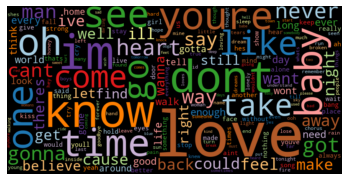

In [385]:
wordcloud(cher_lyrics_cloud['freq'])

##### Robyn lyrics wordcloud:

In [386]:
robyn_lyrics_cloud = count_words(robyn_lyrics)
#robyn_word_cloud

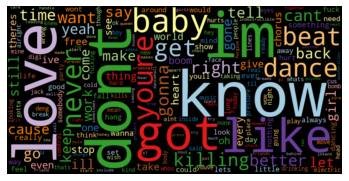

In [388]:
wordcloud(robyn_lyrics_cloud['freq'])

##### Cher twitter descriptions wordcloud:

In [445]:
cher_twitter_cloud = count_words(cher_twitter)
#cher_twitter_cloud = cher_twitter_cloud[cher_twitter_cloud["token"].str.contains(nan) == False]
#df = df[df["team"].str.contains("Team 1") == False]
#cher_twitter_cloud

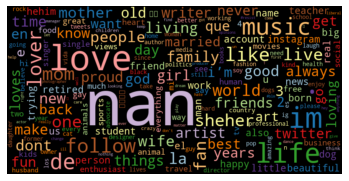

In [446]:
wordcloud(cher_twitter_cloud['freq'])

##### Robyn twitter descriptions wordcloud:

In [447]:
robyn_twitter_cloud = count_words(robyn_twitter)
#robyn_twitter_cloud

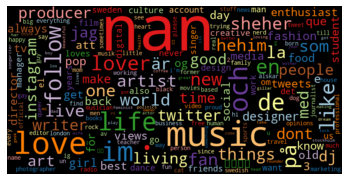

In [448]:
wordcloud(robyn_twitter_cloud['freq'])

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: Many of the same words appear throughout all 4 wordclouds, in addition to being around at the same frequency, hence being about the same size. Additionally, I would say that the overall "theme" is generally the same, especially when comparing the twitter data by artist and the lyrics data by artist. 